<a href="https://colab.research.google.com/github/eunwoo63/-/blob/main/PIU_EDA_which_makes_sense_%E2%AD%90%EF%B8%8F%E2%AD%90%EF%B8%8F%E2%AD%90%EF%B8%8F%E2%AD%90%E2%AD%90%EC%9D%98_%EC%82%AC%EB%B3%B8%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA which makes sense for the *Child Mind Institute — Problematic Internet Use* competition

This notebook shows
- a first analysis of the data
- how to cross-validate a model
- that regression models are better than classification models in this competition, and
- how to tune the thresholds for rounding the regression output.

The notebook uses [polars DataFrames](https://pola.rs/). If you are more fluent with pandas than with polars, this is an opportunity to get to know polars, which is often more efficient than pandas.

Reference:
- [Competition homepage](https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use)

In [1]:
!pip install colorama

In [2]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import numpy as np
import seaborn as sns
import lightgbm
from colorama import Fore, Style
from scipy.optimize import minimize

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score, ConfusionMatrixDisplay

target_labels = ['None', 'Mild', 'Moderate', 'Severe']

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('/content/drive/MyDrive/child-mind-institute-problematic-internet-use/train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

test = (
    pl.read_csv('/content/drive/MyDrive/child-mind-institute-problematic-internet-use/test.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

train

shape: (3_960, 82)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬───────────┬──────┐
│ id       ┆ Basic_Demo ┆ Basic_Demo ┆ Basic_Demo ┆ … ┆ SDS-SDS_To ┆ PreInt_Edu ┆ PreInt_Ed ┆ sii  │
│ ---      ┆ s-Enroll_S ┆ s-Age      ┆ s-Sex      ┆   ┆ tal_T      ┆ Hx-Season  ┆ uHx-compu ┆ ---  │
│ str      ┆ eason      ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ terintern ┆ i64  │
│          ┆ ---        ┆ i64        ┆ i64        ┆   ┆ i64        ┆ enum       ┆ et_…      ┆      │
│          ┆ enum       ┆            ┆            ┆   ┆            ┆            ┆ ---       ┆      │
│          ┆            ┆            ┆            ┆   ┆            ┆            ┆ i64       ┆      │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═══════════╪══════╡
│ 00008ff9 ┆ Fall       ┆ 5          ┆ 0          ┆ … ┆ null       ┆ Fall       ┆ 3         ┆ 2    │
│ 000fd460 ┆ Summer     ┆ 9          ┆ 0          ┆ … ┆ 64         ┆ Summer     ┆ 0         ┆ 0    │
│ 00105258 ┆ Summer     ┆ 10         ┆ 1          ┆ … ┆ 54         ┆ Summer     ┆ 2         ┆ 0    │
│ 00115b9f ┆ Winter     ┆ 9          ┆ 0          ┆ … ┆ 45         ┆ Winter     ┆ 0         ┆ 1    │
│ 0016bb22 ┆ Spring     ┆ 18         ┆ 1          ┆ … ┆ null       ┆ null       ┆ null      ┆ null │
│ …        ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …         ┆ …    │
│ ff8a2de4 ┆ Fall       ┆ 13         ┆ 0          ┆ … ┆ 50         ┆ Fall       ┆ 1         ┆ 1    │
│ ffa9794a ┆ Winter     ┆ 10         ┆ 0          ┆ … ┆ null       ┆ Winter     ┆ 0         ┆ null │
│ ffcd4dbd ┆ Fall       ┆ 11         ┆ 0          ┆ … ┆ 77         ┆ Fall       ┆ 0         ┆ 1    │
│ ffed1dd5 ┆ Spring     ┆ 13         ┆ 0          ┆ … ┆ 47         ┆ Spring     ┆ 1         ┆ 0    │
│ ffef538e ┆ Spring     ┆ 11         ┆ 0          ┆ … ┆ null       ┆ Spring     ┆ 1         ┆ null │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴───────────┴──────┘

The training dataset has 3960 samples (children who participate in the study) and 80 features (not counting the `id` column and the target `sii`). According to the documentation, the full test set comprises about 3800 instances, of which 1400 are public and 2400 private.

# Missing values

All columns have a substantial proportion of missing values, except `id` (not surprisingly) and the three basic demographic columns for sex, age and season of enrollment. Even the target `sii` has missing values:

각 열에서 결측값의 비율을 히스토그램으로 시각화

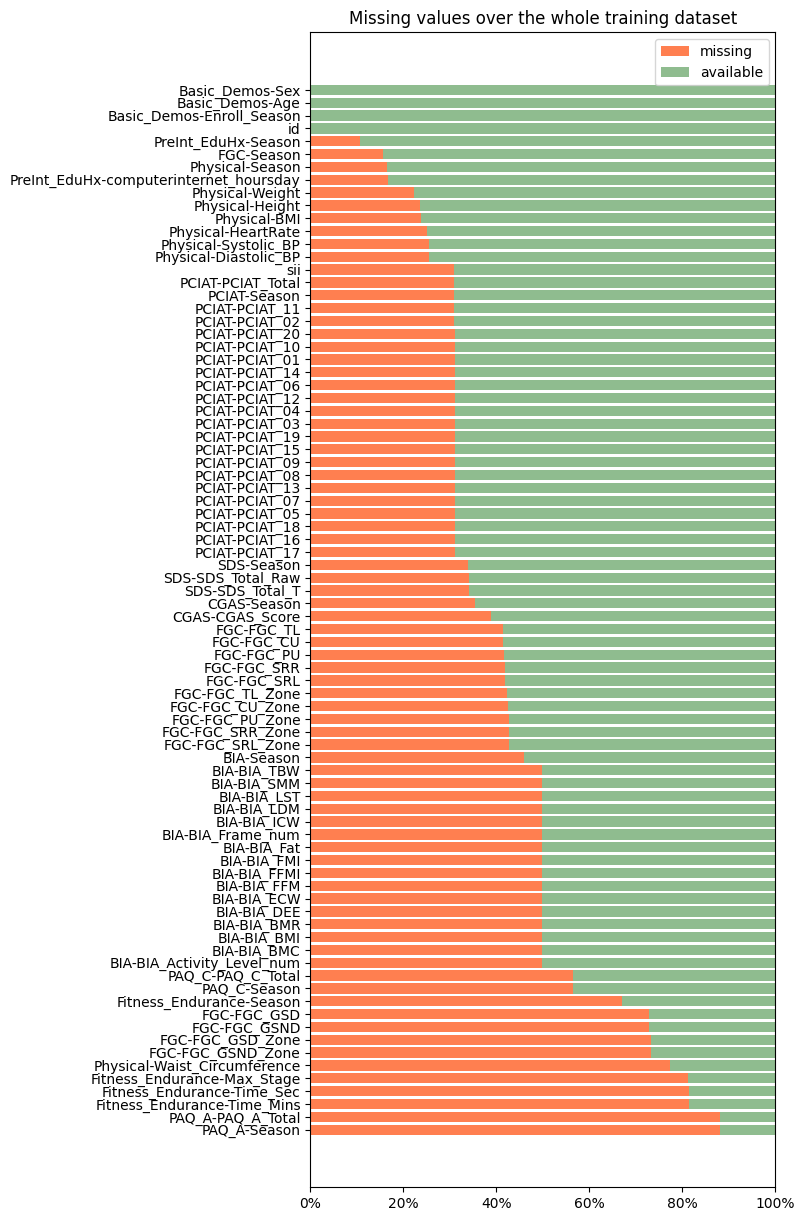

In [6]:
# 결측값 개수를 계산하고, 각 열(null_count)을 기준으로 데이터 프레임으로 변환
missing_count = (
    train
    .null_count()  # 데이터프레임의 각 열의 결측값 개수를 구함
    .transpose(include_header=True,  # 전치하여 행을 열로 바꿈
               header_name='feature',  # 새로운 열에 feature라는 이름을 부여
               column_names=['null_count'])  # null_count라는 열 이름을 설정
    .sort('null_count', descending=True)  # 결측값 개수를 기준으로 내림차순 정렬
    .with_columns((pl.col('null_count') / len(train)).alias('null_ratio'))  # 전체 데이터 대비 결측 비율을 계산하여 'null_ratio' 열 생성
)

# 그래프 시각화 설정
plt.figure(figsize=(6, 15))  # 그래프의 크기를 설정
plt.title('Missing values over the whole training dataset')  # 그래프 제목 설정

# 결측 비율과 비결측 비율을 막대그래프로 생성
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')  # 결측 비율 표시
plt.barh(np.arange(len(missing_count)),
         1 - missing_count.get_column('null_ratio'),  # 비결측 비율 계산
         left=missing_count.get_column('null_ratio'),  # 결측 비율 오른쪽에 비결측 비율이 오도록 설정
         color='darkseagreen', label='available')  # 비결측 부분 색 설정

# Y축에 피처 이름을 설정
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))

# X축을 백분율 형식으로 설정
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)  # X축 범위를 0에서 1로 설정

# 범례 및 그래프 출력
plt.legend()
plt.show()


If we count the missing feature values only for the usable part of the training dataset (samples are usable for supervised training if the target is known), the chart looks slightly different:

타겟데이터(sii)가 있는 샘플들에 대해 결측값을 분석

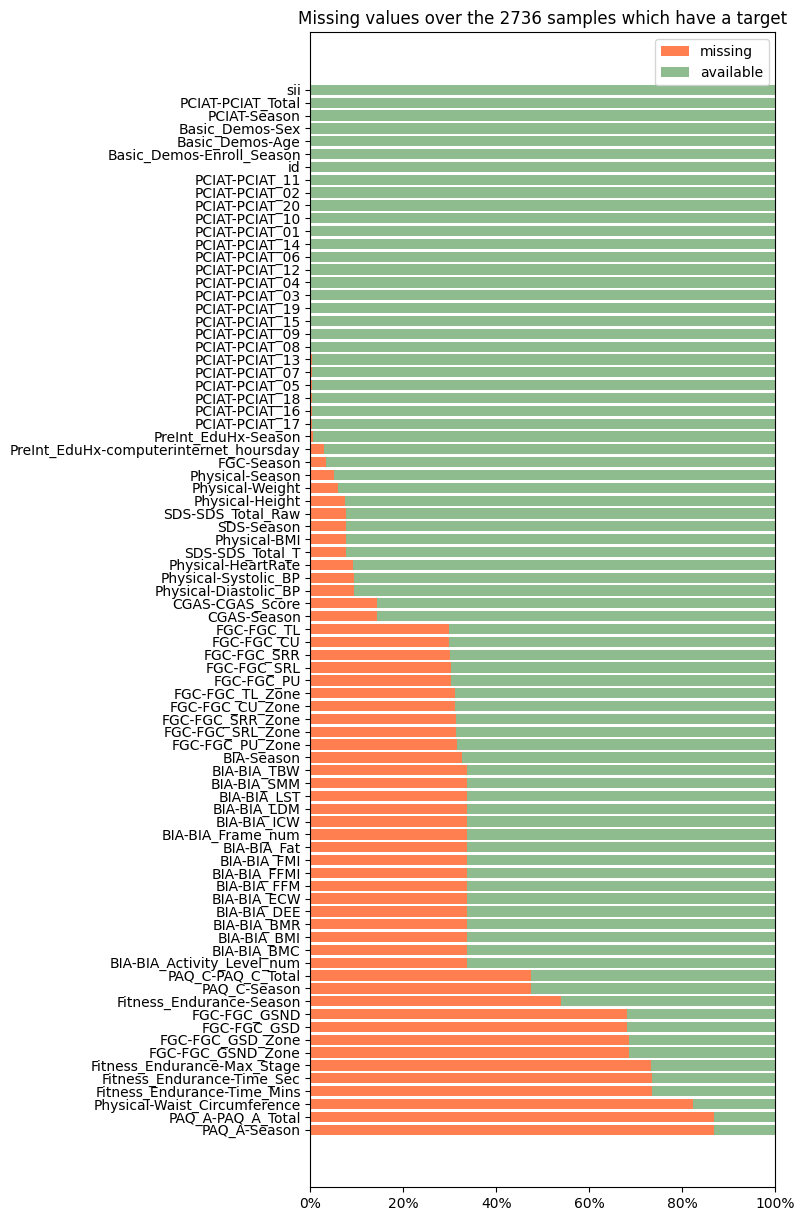

In [7]:
# 타겟 컬럼('sii')에 결측값이 없는 샘플들만 필터링
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())  # 타겟 컬럼 'sii'가 결측값이 아닌 행만 선택
)

# 필터링된 데이터셋에서 결측값 개수를 계산하고, 각 열을 기준으로 데이터 프레임으로 변환
missing_count = (
    supervised_usable
    .null_count()  # 결측값 개수를 각 열에 대해 계산
    .transpose(include_header=True,  # 전치하여 행을 열로 바꿈
               header_name='feature',  # 피처 열 이름 설정
               column_names=['null_count'])  # 결측값 수에 대한 열 이름 설정
    .sort('null_count', descending=True)  # 결측값 개수를 기준으로 내림차순 정렬
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))  # 결측값 비율 계산하여 'null_ratio' 열 생성
)

# 그래프 시각화 설정
plt.figure(figsize=(6, 15))  # 그래프 크기 설정
plt.title(f'Missing values over the {len(supervised_usable)} samples which have a target')  # 타겟이 있는 샘플에 대한 결측값 분석 제목

# 결측 비율과 비결측 비율을 막대그래프로 생성
plt.barh(np.arange(len(missing_count)), missing_count.get_column('null_ratio'), color='coral', label='missing')  # 결측 비율 막대
plt.barh(np.arange(len(missing_count)),
         1 - missing_count.get_column('null_ratio'),  # 비결측 비율 계산
         left=missing_count.get_column('null_ratio'),  # 결측 비율 오른쪽에 비결측 비율이 오도록 설정
         color='darkseagreen', label='available')  # 비결측 부분 색 설정

# Y축에 피처 이름을 설정
plt.yticks(np.arange(len(missing_count)), missing_count.get_column('feature'))

# X축을 백분율 형식으로 설정
plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plt.xlim(0, 1)  # X축 범위를 0에서 1로 설정

# 범례 및 그래프 출력
plt.legend()
plt.show()


# The target

The target `sii` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score:

타겟 변수인 sii는 PCIAT(부모-자녀 인터넷중독검사) 결과가 있는 참가자에게만 존재하며, 이는 PCIAT 총점에 대한 함수

In [9]:
# print(train.select(pl.col('PCIAT-PCIAT_Total').is_null() == pl.col('sii').is_null()).to_series().mean())

# 'PCIAT-PCIAT_Total' 열의 값에 따라 'sii'별로 집계 통계를 계산
(train
 .select(pl.col('PCIAT-PCIAT_Total'))  # PCIAT 총점('PCIAT-PCIAT_Total') 열만 선택
 .group_by(train.get_column('sii'))  # 타겟 변수 'sii'를 기준으로 그룹화
 .agg(
      pl.col('PCIAT-PCIAT_Total').min().alias('PCIAT-PCIAT_Total min'),  # 그룹 내 'PCIAT-PCIAT_Total'의 최솟값을 계산하여 별칭 지정
      pl.col('PCIAT-PCIAT_Total').max().alias('PCIAT-PCIAT_Total max'),  # 그룹 내 'PCIAT-PCIAT_Total'의 최댓값을 계산하여 별칭 지정
      pl.col('PCIAT-PCIAT_Total').len().alias('count')  # 그룹 내 항목 개수 계산하여 별칭 지정
 )
 .sort('sii')  # 'sii'를 기준으로 오름차순 정렬
)


shape: (5, 4)
┌──────┬───────────────────────┬───────────────────────┬───────┐
│ sii  ┆ PCIAT-PCIAT_Total min ┆ PCIAT-PCIAT_Total max ┆ count │
│ ---  ┆ ---                   ┆ ---                   ┆ ---   │
│ i64  ┆ i64                   ┆ i64                   ┆ u32   │
╞══════╪═══════════════════════╪═══════════════════════╪═══════╡
│ null ┆ null                  ┆ null                  ┆ 1224  │
│ 0    ┆ 0                     ┆ 30                    ┆ 1594  │
│ 1    ┆ 31                    ┆ 49                    ┆ 730   │
│ 2    ┆ 50                    ┆ 79                    ┆ 378   │
│ 3    ┆ 80                    ┆ 93                    ┆ 34    │
└──────┴───────────────────────┴───────────────────────┴───────┘

The test dataset doesn't have any PCIAT columns (otherwise predictions would be trivial).

**Insight:**
1. We should focus on predicting the target from all other features except the PCIAT results.
2. We know the target only for two thirds of the samples. The samples without target can perhaps be used for semi-supervised learning.
3. We can directly predict `sii` (this is the value we have to submit), or we can predict `PCIAT-PCIAT_Total` and then transform this prediction to a `sii` prediction for submission. As `PCIAT-PCIAT_Total` is more granular and informative than `sii`, training to predict `PCIAT-PCIAT_Total` has the potential to produce a better model.


우리는 타겟(sii)을 PCIAT 결과를 제외한 다른 모든 피처로부터 예측하는 데 집중해야 합니다. 타겟 값은 샘플 중 약 3분의 2에서만 알 수 있으며, 타겟이 없는 샘플들은 **반지도 학습(semi-supervised learning)**에 활용할 수 있을 가능성이 있습니다.

우리는 sii를 직접 예측할 수도 있고, PCIAT-PCIAT_Total을 예측한 후 이 예측값을 sii로 변환하여 제출할 수도 있습니다. PCIAT-PCIAT_Total은 sii보다 더 세밀하고 정보가 풍부하기 때문에 PCIAT-PCIAT_Total 예측을 위한 학습이 더 나은 모델을 생성할 가능성이 있습니다.

In [10]:
print('Columns missing in test:')
print([f for f in train.columns if f not in test.columns])

Columns missing in test:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'sii']


# Demographics

The study participants are between 5 and 22 years old. There are twice as many boys as girls.

참가자정보에 대한 eda
-나이,성별

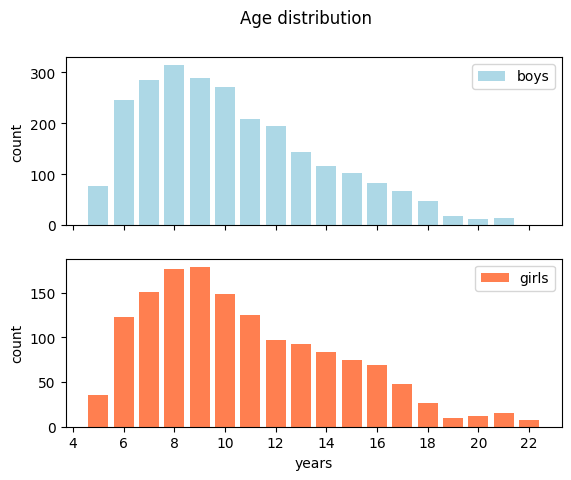

In [11]:
_, axs = plt.subplots(2, 1, sharex=True)
for sex in range(2):
    ax = axs.ravel()[sex]
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('Basic_Demos-Age').value_counts()
    ax.bar(vc.get_column('Basic_Demos-Age'),
           vc.get_column('count'),
           color=['lightblue', 'coral'][sex],
           label=['boys', 'girls'][sex])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('count')
    ax.legend()
plt.suptitle('Age distribution')
axs.ravel()[1].set_xlabel('years')
plt.show()

The four seasons of enrollment have similar frequencies:

계절 확인 - 균일함

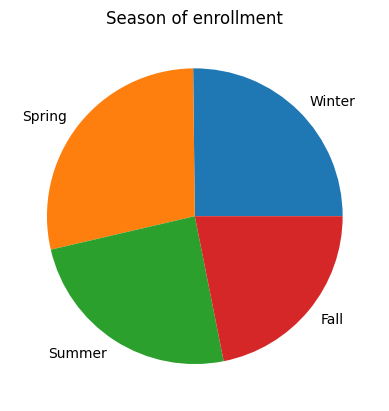

In [12]:
vc = train.get_column('Basic_Demos-Enroll_Season').value_counts()
plt.pie(vc.get_column('count'), labels=vc.get_column('Basic_Demos-Enroll_Season'))
plt.title('Season of enrollment')
plt.show()

Boys have a slightly higher risk of internet addiction than girls:

타겟(sii지수)에 따른 성별확인

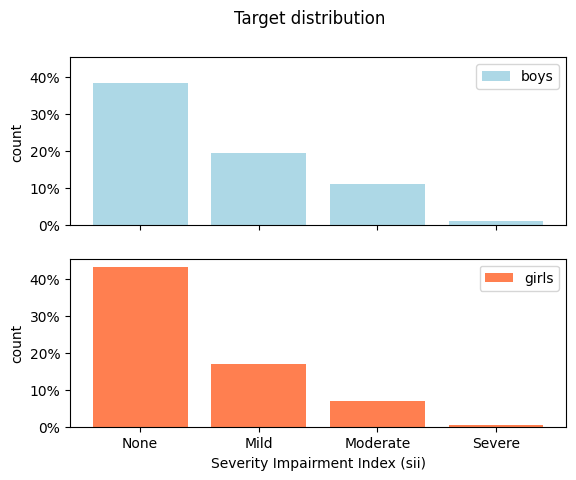

In [14]:
# 서브플롯을 생성하여 두 개의 히스토그램을 나란히 배치, x축과 y축을 공유
_, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# 성별을 기준으로 타겟 분포를 시각화
for sex in range(2):  # 0과 1로 구분된 성별 값(예: 0=남자, 1=여자)에 대해 반복
    ax = axs.ravel()[sex]  # 서브플롯을 성별에 맞게 설정

    # 성별로 필터링한 데이터에서 타겟 변수 'sii'의 값의 빈도를 계산
    vc = train.filter(pl.col('Basic_Demos-Sex') == sex).get_column('sii').value_counts()

    # 막대그래프로 각 성별에 대해 'sii' 값의 비율을 표시
    ax.bar(vc.get_column('sii'),  # x축: 'sii' 값
           vc.get_column('count') / vc.get_column('count').sum(),  # y축: 각 'sii' 값의 비율 계산
           color=['lightblue', 'coral'][sex],  # 색상: 남자는 연한 파란색, 여자는 산호색
           label=['boys', 'girls'][sex])  # 레이블: 남자는 boys, 여자는 girls로 표시

    # x축 눈금을 4개로 설정하고 타겟 레이블을 추가
    ax.set_xticks(np.arange(4), target_labels)

    # y축을 백분율 형식으로 설정
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

    # y축 레이블 설정
    ax.set_ylabel('count')

    # 범례 추가
    ax.legend()

# 그래프 전체 제목 설정
plt.suptitle('Target distribution')

# 두 번째 서브플롯의 x축 레이블 설정
axs.ravel()[1].set_xlabel('Severity Impairment Index (sii)')

# 그래프 출력
plt.show()


# A look at selected other features

Some children had their body–mass index measured twice in the study. Comparing the two reported values gives an impression of data quality:


이 코드는 'Physical-BMI'와 'BIA-BIA_BMI' 값 간의 차이를 시각화하여, 두 값의 차이가 30% 이상인 경우 해당 점을 빨간색으로 표시함으로써 데이터정확도에 대한 체크

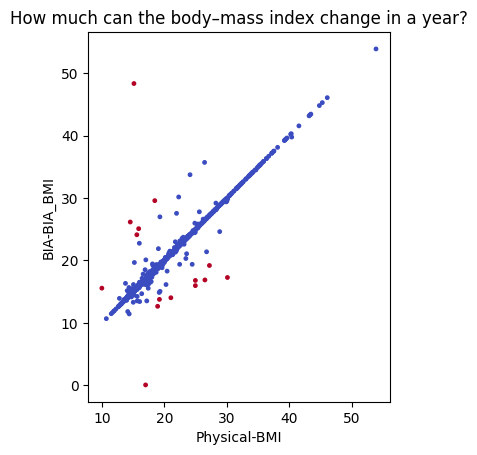

In [15]:
# BMI 비율을 계산하여 0.7 미만 또는 1.3 초과 여부에 따라 색상 설정
bmi_ratio = train.select(pl.col('Physical-BMI') / pl.col('BIA-BIA_BMI')).to_series()  # 'Physical-BMI'와 'BIA-BIA_BMI'의 비율 계산
color = (bmi_ratio < 0.7) | (bmi_ratio > 1.3)  # 비율이 0.7 미만 또는 1.3 초과일 경우 True (차이가 30% 이상)

# 산점도 생성: 두 BMI 값을 비교하고 특정 조건에 따라 색상을 지정
plt.scatter(train.get_column('Physical-BMI'),  # x축: Physical-BMI
            train.get_column('BIA-BIA_BMI'),  # y축: BIA-BIA_BMI
            s=6,  # 점의 크기 설정
            cmap='coolwarm',  # 색상 맵을 coolwarm으로 설정
            c=color)  # 차이가 큰 점을 빨간색으로 표시

# 그래프를 정사각형 비율로 설정
plt.gca().set_aspect('equal')

# x축과 y축 라벨 설정
plt.xlabel('Physical-BMI')
plt.ylabel('BIA-BIA_BMI')

# 그래프 제목 설정
plt.title('How much can the body–mass index change in a year?')

# 그래프 출력
plt.show()


Systolic blood pressure should always be higher than diastolic:

In [ ]:
혈압체크. 빨간점인 타겟들은 혈압에 문제가 있을 가능성(비정상적인 혈압 패턴)

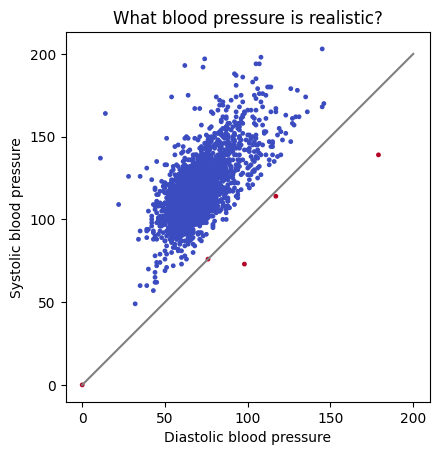

In [18]:
# 수축기 혈압이 이완기 혈압보다 낮은 경우 True로 설정
color = train.get_column('Physical-Systolic_BP') <= train.get_column('Physical-Diastolic_BP')

# 산점도 생성: 이완기 혈압을 x축, 수축기 혈압을 y축으로 설정
plt.scatter(train.get_column('Physical-Diastolic_BP'),  # x축: 이완기 혈압
            train.get_column('Physical-Systolic_BP'),  # y축: 수축기 혈압
            s=6,  # 점의 크기 설정
            cmap='coolwarm',  # 색상 맵을 coolwarm으로 설정
            c=color)  # 비정상적인 혈압 패턴은 다른 색으로 표시

# 그래프를 정사각형 비율로 설정
plt.gca().set_aspect('equal')

# 수축기 혈압이 이완기 혈압보다 항상 커야 하므로, 대각선 기준선을 추가하여 정상적인 혈압 패턴을 보여줌
plt.plot([0, 200], [0, 200], color='gray')  # 대각선 (이완기 = 수축기)을 표시

# x축과 y축 라벨 설정
plt.xlabel('Diastolic blood pressure')  # 이완기 혈압 라벨
plt.ylabel('Systolic blood pressure')  # 수축기 혈압 라벨

# 그래프 제목 설정
plt.title('What blood pressure is realistic?')

# x축과 y축 눈금을 0부터 200까지 5등분하여 표시
plt.xticks(np.linspace(0, 200, 5))  # x축 눈금
plt.yticks(np.linspace(0, 200, 5))  # y축 눈금

# 그래프 출력
plt.show()


심박수 체크

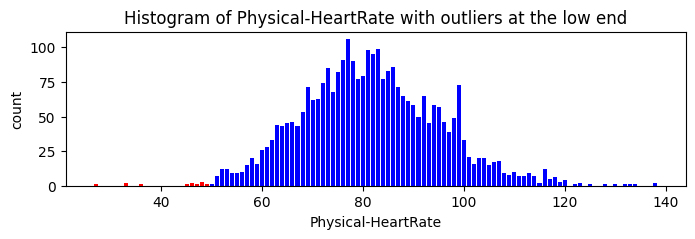

In [19]:
# 'Physical-HeartRate' 열의 값 빈도 계산 (각각의 심박수 값에 대한 카운트)
vc = train.get_column('Physical-HeartRate').value_counts()

# 심박수가 50 미만인 경우 빨간색, 그 외는 파란색으로 색 지정
color = np.where(vc.get_column('Physical-HeartRate') < 50, 'r', 'b')

# 그래프 크기 설정
plt.figure(figsize=(8, 2))

# 그래프 제목 설정: "Physical-HeartRate"의 히스토그램, 저값에서 이상치(outlier)가 존재함을 나타냄
plt.title('Histogram of Physical-HeartRate with outliers at the low end')

# 히스토그램을 생성: 심박수 값에 따른 빈도수로 막대그래프를 그리며 색상 설정
plt.bar(vc.get_column('Physical-HeartRate'), vc.get_column('count'), color=color)

# x축 라벨 설정
plt.xlabel('Physical-HeartRate')

# y축 라벨 설정
plt.ylabel('count')

# 그래프 출력
plt.show()


The sleep disturbance scale questionnaire gives a raw score between 0 and 100. The raw score is then converted to a t score. It looks like you can drop one of the features without losing information.

The sleep disturbance scale t score is defined so that the average is 50 and the standard deviation is 10. We apparently have 29 children whose sleep is five standard deviations worse than the average of the general population. Is that plausible?

수면 방해 척도 시각화. T점수로 변환. 평균 50 표준편차10으로, 이상치가 많이 보임.

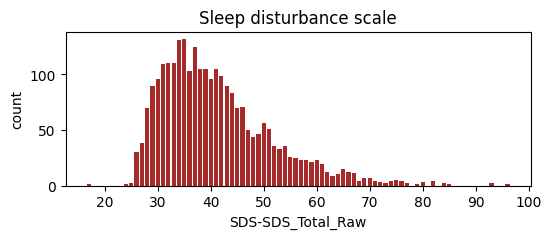

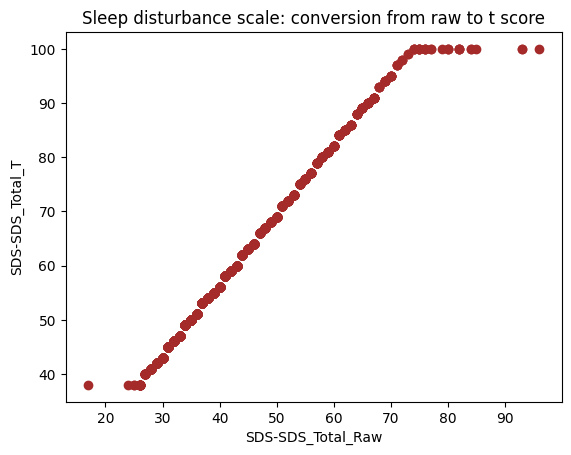

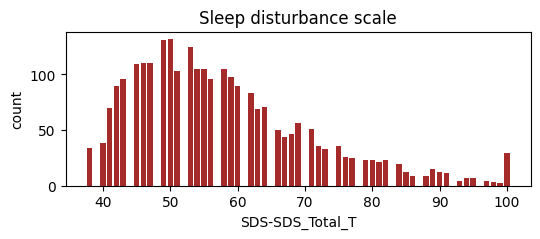

In [21]:
# 'SDS-SDS_Total_Raw' 열의 값 빈도 계산 (각각의 원시 수면 방해 척도 점수에 대한 카운트)
vc = train.get_column('SDS-SDS_Total_Raw').value_counts()

# 그래프 크기 설정
plt.figure(figsize=(6, 2))

# 그래프 제목 설정: 수면 방해 척도 원시 점수 분포
plt.title('Sleep disturbance scale')

# 원시 수면 방해 척도 점수에 대한 히스토그램 생성
plt.bar(vc.get_column('SDS-SDS_Total_Raw'), vc.get_column('count'), color='brown')

# x축 라벨 설정: 원시 점수
plt.xlabel('SDS-SDS_Total_Raw')

# y축 라벨 설정: 카운트
plt.ylabel('count')

# 그래프 출력
plt.show()

# 원시 수면 방해 척도 점수와 T 점수 간의 관계 시각화
plt.title('Sleep disturbance scale: conversion from raw to t score')

# 원시 수면 방해 척도 점수와 T 점수 간의 산점도 생성
plt.scatter(train.get_column('SDS-SDS_Total_Raw'),
            train.get_column('SDS-SDS_Total_T'),
            color='brown')

# x축 라벨 설정: 원시 점수
plt.xlabel('SDS-SDS_Total_Raw')

# y축 라벨 설정: T 점수
plt.ylabel('SDS-SDS_Total_T')

# 그래프 출력
plt.show()

# 'SDS-SDS_Total_T' 열의 값 빈도 계산 (각각의 T 점수에 대한 카운트)
vc = train.get_column('SDS-SDS_Total_T').value_counts()

# 그래프 크기 설정
plt.figure(figsize=(6, 2))

# 그래프 제목 설정: 수면 방해 척도 T 점수 분포
plt.title('Sleep disturbance scale')

# T 점수에 대한 히스토그램 생성
plt.bar(vc.get_column('SDS-SDS_Total_T'), vc.get_column('count'), color='brown')

# x축 라벨 설정: T 점수
plt.xlabel('SDS-SDS_Total_T')

# y축 라벨 설정: 카운트
plt.ylabel('count')

# 그래프 출력
plt.show()


**Insight:** There are many outliers. We have to decide whether to keep them, modify them ([winsorizing](https://en.wikipedia.org/wiki/Winsorizing)) or drop them.

# Actigraphy files (time series)

> [Actigraphy](https://en.wikipedia.org/wiki/Actigraphy) is a non-invasive method of monitoring human rest/activity cycles. A small actigraph unit, also called an actimetry sensor, is worn for a week or more to measure gross motor activity. The unit is usually in a wristwatch-like package worn on the wrist. The movements the actigraph unit undergoes are continually recorded and some units also measure light exposure. (Wikipedia)

We have actigraphy files for a quarter of the participants (996 to be precise). The file name is always `part-0.parquet`.

Looking at the file of participant `id=0417c91e`, a six-year old right-handed girl, we see that this participant started to use the accelerometer on a Tuesday (weekday=2) of the second quarter of the year at second 44100 of the day (12:15 PM), 5 days after the PCIAT test. She gave the accelerometer back on the 53rd day after the PCIAT test, a Monday of the third quarter, at 9:08 AM.

The competition data page says that `time_of_day` is in format `%H:%M:%S.%9f`. This is obviously not true. `time_of_day` is measured in nanoseconds since midnight.


Actigraphy파일 (시계열 데이터)
Actigraphy는 인간의 휴식/활동 주기를 모니터링하는 방법입니다. 작은 Actigraphy 장치, 또는 actimetry 센서라고도 불리는 이 장치는 한 주 또는 그 이상 동안 착용하여 큰 동작 활동을 측정합니다. 이 장치는 일반적으로 손목에 착용하는 시계와 비슷한 형태로 되어 있습니다. Actigraphy장치는 지속적으로 움직임을 기록하며, 일부 장치는 빛 노출도 측정합니다.
우리는 996명의 참가자에 대해 액티그래피 파일을 가지고 있습니다.

파일 이름은 항상 part-0.parquet 입니다.

참가자 id=0417c91e (6세의 오른손잡이 여자 아이)의 파일을 살펴보면, 이 참가자는 두 번째 분기의 화요일 (요일=2) 오후 12시 15분(일일 초시각 44100초)에 가속도계를 사용하기 시작했습니다. 이는 PCIAT 테스트에서 5일 후의 일이었습니다. 그리고 그녀는 PCIAT 테스트 후 53일째인 세 번째 분기의 월요일 오전 9시 8분에 가속도계를 반환했습니다.

경쟁 데이터 페이지에 따르면, time_of_day는 %H:%M:%S.%9f 형식이라고 되어 있지만, 이는 사실이 아닙니다. time_of_day는 자정부터의 나노초 단위로 측정됩니다.

In [23]:
actigraphy = pl.read_parquet('/content/drive/MyDrive/child-mind-institute-problematic-internet-use/series_train.parquet/id=0417c91e/part-0.parquet')
actigraphy


shape: (287_179, 13)
┌────────┬───────────┬───────────┬───────────┬───┬──────────────┬─────────┬─────────┬──────────────┐
│ step   ┆ X         ┆ Y         ┆ Z         ┆ … ┆ time_of_day  ┆ weekday ┆ quarter ┆ relative_dat │
│ ---    ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---          ┆ ---     ┆ ---     ┆ e_PCIAT      │
│ u32    ┆ f32       ┆ f32       ┆ f32       ┆   ┆ i64          ┆ i8      ┆ i8      ┆ ---          │
│        ┆           ┆           ┆           ┆   ┆              ┆         ┆         ┆ f32          │
╞════════╪═══════════╪═══════════╪═══════════╪═══╪══════════════╪═════════╪═════════╪══════════════╡
│ 0      ┆ 0.014375  ┆ -0.020112 ┆ -0.995358 ┆ … ┆ 441000000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 1      ┆ 0.014167  ┆ -0.023278 ┆ -0.996164 ┆ … ┆ 441050000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 2      ┆ 0.014036  ┆ -0.022964 ┆ -0.99632  ┆ … ┆ 441100000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 3      ┆ 0.013593  ┆ -0.022048 ┆ -0.996762 ┆ … ┆ 441150000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 4      ┆ -0.061772 ┆ -0.065317 ┆ -0.973063 ┆ … ┆ 447800000000 ┆ 2       ┆ 2       ┆ 5.0          │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ …      ┆ …         ┆ …         ┆ …         ┆ … ┆ …            ┆ …       ┆ …       ┆ …            │
│ 287174 ┆ -0.407433 ┆ 0.091612  ┆ -0.377763 ┆ … ┆ 328750000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287175 ┆ -0.703572 ┆ 0.016187  ┆ 0.15956   ┆ … ┆ 328800000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287176 ┆ -0.209607 ┆ -0.4697   ┆ 0.636573  ┆ … ┆ 328850000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287177 ┆ -0.390378 ┆ 0.284386  ┆ 0.147654  ┆ … ┆ 328900000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
│ 287178 ┆ -0.48903  ┆ 0.179624  ┆ -0.509611 ┆ … ┆ 328950000000 ┆ 1       ┆ 3       ┆ 53.0         │
│        ┆           ┆           ┆           ┆   ┆ 00           ┆         ┆         ┆              │
└────────┴───────────┴───────────┴───────────┴───┴──────────────┴─────────┴─────────┴──────────────┘

We can plot diagrams of the time series in this file. What can we see?
1. We clearly see a daily pattern.
2. We see that the girl wore the accelerometer for 31 days and then took it off.
3. The dataset has a non-wear_flag column, but that flag is always zero for this participant.
4. The girl is in an environment where the illuminance exceeds 2500 [lux](https://en.wikipedia.org/wiki/Lux) every day (the device cannot measure more than 2500 lux). Such a high illuminance means that she is outdoors or in a room with huge windows.
5. The girl moves a lot: she has enmo values above 2 almost every day.
6. The time series usually contain measurements every 5 seconds, but some time steps are missing. It is not documented under what conditions time steps are skipped.

**Insight:**
- Use the ENMO and light columns and don't trust the non-wear_flag!
- The ENMO and light columns offer themselves for analysis with a one-dimensional convolutional neural network, but if we want to start simple, we can use some basic aggregations (mean, variance, ...) of the time series as features for a gradient-boosting model.


우리는 이 파일의 시계열 데이터로 다이어그램을 그릴 수 있습니다. 무엇을 알 수 있을까요?

우리는 명확하게 일일 패턴을 확인할 수 있습니다.
이 소녀는 가속도계를 31일 동안 착용한 후 이를 벗었습니다.
데이터셋에는 non-wear_flag라는 열이 있지만, 이 참가자에 대해서는 그 값이 항상 0입니다.
이 소녀는 매일 2500 lux를 초과하는 조도를 경험하는 환경에 있었습니다 (장치가 2500 lux 이상을 측정할 수 없음). 이렇게 높은 조도는 그녀가 야외에 있거나 큰 창문이 있는 방에 있다는 것을 의미합니다.
이 소녀는 매우 활동적입니다: 거의 매일 ENMO 값이 2를 초과합니다.
시계열 데이터는 일반적으로 5초 간격으로 측정되지만, 일부 시간 간격은 누락되어 있습니다. 시간 간격이 누락되는 조건에 대해서는 문서화되어 있지 않습니다.

인사이트:
non-wear_flag는 신뢰하지 말고, 대신 ENMO와 light 열을 사용하세요!
ENMO와 light 열은 1D 합성곱 신경망(CNN) 분석에 적합하지만, 더 간단히 시작하려면 시계열의 기본적인 집계(평균, 분산 등)를 특징으로 사용하여 그래디언트 부스팅 모델을 만들 수 있습니다.

시계열 데이터 전처리후 시각화

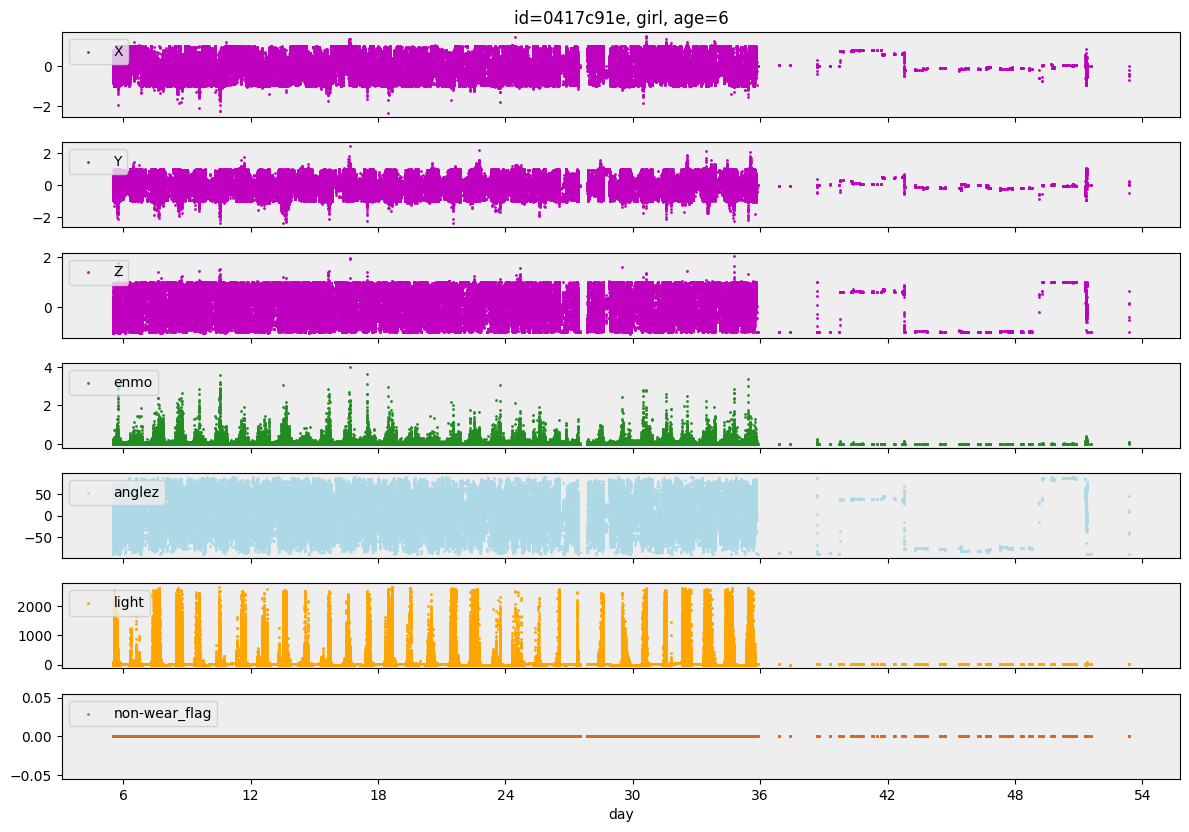

In [38]:
def analyze_actigraphy(id, only_one_week=False, small=False):
    # 지정된 ID를 가진 actigraphy 데이터를 parquet 파일에서 읽음
    actigraphy = pl.read_parquet(f'/content/drive/MyDrive/child-mind-institute-problematic-internet-use/series_train.parquet/id={id}/part-0.parquet')

    # 'relative_date_PCIAT'와 'time_of_day'를 합쳐서 'day' 변수에 저장. 86400e9을 나눠 나노초를 일 단위로 변환
    day = actigraphy.get_column('relative_date_PCIAT') + actigraphy.get_column('time_of_day') / 86400e9

    # 특정 ID에 해당하는 train 데이터를 필터링하여 age와 sex를 가져옴
    sample = train.filter(pl.col('id') == id)
    age = sample.get_column('Basic_Demos-Age').item()  # 연령
    sex = ['boy', 'girl'][sample.get_column('Basic_Demos-Sex').item()]  # 성별 ('boy' 또는 'girl')

    # 새로운 열 추가: (1) 각 시간 간격의 차이('diff_seconds')와 (2) X, Y, Z 좌표의 벡터 크기('norm')
    actigraphy = (
        actigraphy
        .with_columns(
            (day.diff() * 86400).alias('diff_seconds'),  # 각 연속적인 시간 차이를 초 단위로 변환
            (np.sqrt(np.square(pl.col('X')) + np.square(pl.col('Y')) + np.square(pl.col('Z'))).alias('norm'))  # X, Y, Z 좌표의 벡터 크기 계산
        )
    )

    # 분석할 데이터를 일주일치로 제한할 경우
    if only_one_week:
        start = np.ceil(day.min())  # 시작 날짜
        mask = (start <= day.to_numpy()) & (day.to_numpy() <= start + 7*3)  # 일주일 기간 내에 있는 데이터만 포함
        mask &= ~ actigraphy.get_column('non-wear_flag').cast(bool).to_numpy()  # 'non-wear_flag'가 False인 데이터만 포함
    else:
        mask = np.full(len(day), True)  # 전체 데이터를 사용할 경우

    # 시각화할 데이터와 색상 설정: small=True일 때는 일부 열만 포함, small=False일 때는 모든 열 포함
    if small:
        timelines = [
            ('enmo', 'forestgreen'),
            ('light', 'orange'),
        ]
    else:
        timelines = [
            ('X', 'm'),
            ('Y', 'm'),
            ('Z', 'm'),
            # ('norm', 'c'),  # 벡터 크기(norm)를 포함하지 않음
            ('enmo', 'forestgreen'),  # enmo 데이터
            ('anglez', 'lightblue'),  # anglez 데이터
            ('light', 'orange'),  # light 데이터
            ('non-wear_flag', 'chocolate')  # 착용하지 않은 경우
            # ('diff_seconds', 'k'),  # 시간 간격 차이 포함하지 않음
        ]

    # 타임라인 데이터를 플롯으로 시각화
    _, axs = plt.subplots(len(timelines), 1, sharex=True, figsize=(12, len(timelines) * 1.1 + 0.5))
    for ax, (feature, color) in zip(axs, timelines):
        ax.set_facecolor('#eeeeee')  # 축 배경색 설정
        # scatter 플롯 생성: day 축을 기준으로, mask 조건을 만족하는 feature 데이터에 해당하는 값을 색상과 함께 플롯
        ax.scatter(day.to_numpy()[mask],
                   actigraphy.get_column(feature).to_numpy()[mask],
                   color=color, label=feature, s=1)
        ax.legend(loc='upper left', facecolor='#eeeeee')  # 범례 추가
        if feature == 'diff_seconds':  # 'diff_seconds'일 때 y축 범위 제한
            ax.set_ylim(-0.5, 20.5)
    axs[-1].set_xlabel('day')  # 마지막 축의 x축 라벨 설정
    axs[-1].xaxis.set_major_locator(MaxNLocator(integer=True))  # x축에 정수 위치 설정
    plt.tight_layout()  # 레이아웃 자동 조정
    axs[0].set_title(f'id={id}, {sex}, age={age}')  # 첫 번째 축에 제목 추가
    plt.show()  # 플롯 출력

# 함수 호출: 특정 ID와 매개변수 설정
analyze_actigraphy('0417c91e', only_one_week=False)


Let's look at a few more time series. The next time series covers only one day, I don't think it helps predict problematic Internet use:

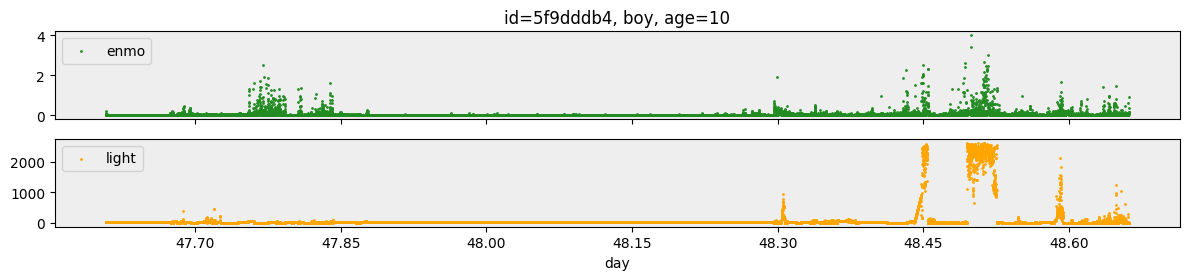

In [39]:
analyze_actigraphy('5f9dddb4', small=True)

Our next participant, a 15-year old left-handed boy, never moves much (enmo < 0.5), and he saw daylight only once in a whole month:

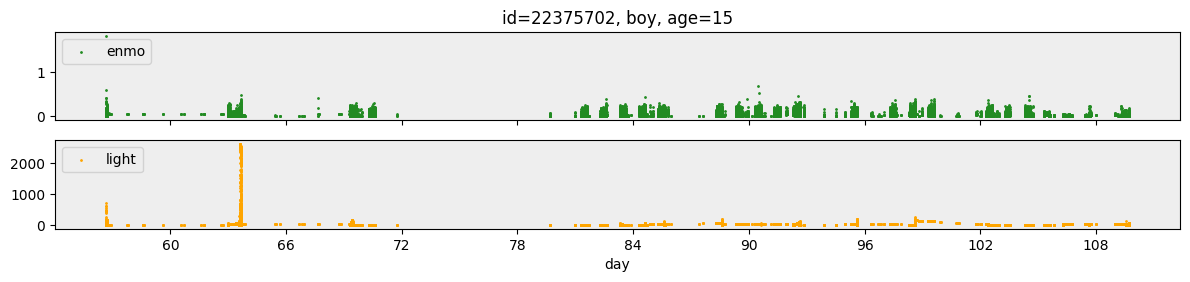

In [40]:
analyze_actigraphy('22375702', small=True)

Next one: This poor nine-year old boy (id 0668373f) had a quiet life for two and a half weeks, then he had an accident with an acceleration of 12 g. After the accident, the device immediately stopped recording data; let's hope that the boy survived!

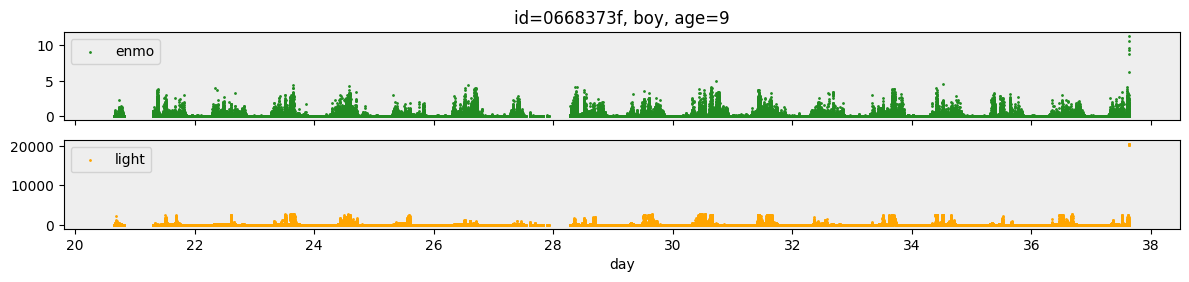

In [41]:
analyze_actigraphy('0668373f', small=True)

Our last time series shows some strange ramps in the illuminance measurement. It looks like there was missing data and somebody filled the blanks by linear interpolation. I'd prefer to get the raw data without undocumented preprocessing applied.

마지막 시계열데이터에서는 조도 측정값에 이상한 경사가 보입니다. 데이터가 누락되었고 누군가가 빈 칸을 선형 보간법으로 채운 것처럼 보입니다.

In [42]:
analyze_actigraphy('bc4eaf77', small=True)

**Insight:** We need a lot of data cleaning before we can use the actigraphy data.

Did you notice that for some participants I mentioned whether they were right- or left-handed? Did you wonder how I came to that conclusion? It's simple. The actigraphy device is fixed to the wrist of the non-dominant arm. Depending on the whether you choose the left or right wrist, the X coordinate of the accelerometer will return a positive or negative average.

가속도계의 x좌표의 평균을 보고 오른손잡이 왼손잡이여부를 판단가능







# A simple classification model

We can model the competition as a multiclass classification task with the four classes 'None', 'Mild', 'Moderate', 'Severe'.

It is important that we select only the samples where the target `sii` is known and that we drop all PCIAT columns. We don't use the accelerometer data for this simple model.

We use the [scikit-learn implementation of the quadratic kappa score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html) for evaluation.

우리는 이 대회를 'None', 'Mild', 'Moderate', 'Severe'라는 네 가지 클래스를 가진 다중 클래스 분류 문제로 모델링할 수 있습니다.

중요한 점은 타겟인 sii가 알려진 샘플만 선택하고, 모든 PCIAT 관련 컬럼을 제거하는 것입니다. 이 간단한 모델에서는 가속도계 데이터는 사용하지 않습니다.

평가는 scikit-learn의 이차 가중 Cohen's Kappa 점수를 사용합니다.

In [44]:
# 'sii' 열을 타겟 변수로 설정하고, 'id'와 'sii', 'PCIAT' 관련 열들을 제외한 나머지 특성들을 X로 설정
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

# StratifiedKFold 교차 검증을 위한 설정
kf = StratifiedKFold(shuffle=True, random_state=1)

# 예측 결과를 저장할 배열 초기화
oof = np.zeros(len(y), dtype=int)

# 교차 검증을 통한 모델 학습 및 평가
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]  # 학습 데이터
    X_va = X.iloc[idx_va]  # 검증 데이터
    y_tr = y[idx_tr]       # 학습 레이블
    y_va = y[idx_va]       # 검증 레이블

    # LightGBM 분류기 모델 초기화 및 학습
    model = lightgbm.LGBMClassifier(verbose=-1)
    model.fit(X_tr, y_tr)

    # 예측 결과 및 평가
    y_pred = model.predict(X_va)

    # Cohen's Kappa score 계산 (quadratic weight)
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")  # 각 폴드별 점수 출력

    # 검증 데이터에 대한 예측 결과 저장
    oof[idx_va] = y_pred

# 전체 데이터에 대한 최종 Cohen's Kappa score 계산
score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (classification with LightGBM){Style.RESET_ALL}")  # 최종 점수 출력


# Fold 0: score=0.354
# Fold 1: score=0.350
# Fold 2: score=0.256
# Fold 3: score=0.317
# Fold 4: score=0.379
# Overall: score=0.331 (classification with LightGBM)


The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) helps understand the output of the model.

> Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class \[...\]. The diagonal of the matrix therefore represents all instances that are correctly predicted. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another). (Wikipedia)

The most common mislabeling of our classification model is indicated by the highest non-diagonal entry of the confusion matrix: It classifies the mildly problematic Internet use of 454 children as non-problematic.

confusion maxtrix로 단순분류모델의 정확도 시각화하기

In [45]:
ConfusionMatrixDisplay.from_predictions(y, oof)
plt.title('Confusion matrix for the simple classification model')
plt.xticks(np.arange(4), target_labels)
plt.yticks(np.arange(4), target_labels)
plt.show()

# A simple regression model is better

We can use a regression model as well, and it turns out that the regression model is better than the classification model (it gets the higher cv score). We interpret the target as a number from 0 to 3, and we round the predictions of the regression model to the nearest integer.

회귀모델사용 타겟을 0부터 3의 정수로 해석하고, 결과값을 정수로 반올림하여 사용.

In [47]:
# 타겟 변수 'sii'를 종속 변수로 선택하고, 독립 변수(X)는 'id', 'sii' 및 PCIAT 관련 열들을 제외하여 선택합니다.
y = supervised_usable.get_column('sii')
X = supervised_usable.drop('id', 'sii', '^PCIAT.*$').to_pandas()

# StratifiedKFold를 사용하여 교차 검증을 수행합니다. 이는 데이터의 클래스 분포가 각 훈련 및 검증 세트에서 동일하도록 보장합니다.
kf = StratifiedKFold(shuffle=True, random_state=1)

# OOF(Out-Of-Fold) 예측을 저장할 배열을 초기화합니다: 하나는 원시 예측(반올림 전 실수 값)용이고, 다른 하나는 반올림된 예측(최종 클래스)용입니다.
oof_raw = np.zeros(len(y), dtype=float)  # 원시 예측(연속 값, 반올림 전)
oof = np.zeros(len(y), dtype=int)  # 반올림된 예측(최종 예측된 클래스)

# 교차 검증의 각 폴드에 대해 반복합니다.
for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
    X_tr = X.iloc[idx_tr]  # 현재 폴드의 훈련 데이터
    X_va = X.iloc[idx_va]  # 현재 폴드의 검증 데이터
    y_tr = y[idx_tr]  # 현재 폴드의 훈련 타겟 변수
    y_va = y[idx_va]  # 현재 폴드의 검증 타겟 변수

    # LightGBM 회귀 모델을 생성하고 훈련 데이터로 학습시킵니다.
    model = lightgbm.LGBMRegressor(verbose=-1)
    model.fit(X_tr, y_tr.to_numpy())

    # 검증 데이터에 대한 예측을 수행합니다(원시 예측값).
    y_pred = model.predict(X_va)

    # 이 폴드에 대한 원시 예측 값을 저장합니다.
    oof_raw[idx_va] = y_pred

    # 예측 값을 가장 가까운 정수로 반올림하여 클래스 예측값으로 변환합니다.
    y_pred = y_pred.round(0).astype(int)

    # 현재 폴드의 예측 결과와 실제 값을 비교하여 quadratic kappa 점수를 계산합니다.
    score = cohen_kappa_score(y_va, y_pred, weights='quadratic')
    print(f"# Fold {fold}: {score=:.3f}")  # 현재 폴드에 대한 kappa 점수를 출력합니다.

    # 반올림된 예측 값을 OOF 배열에 저장합니다.
    oof[idx_va] = y_pred

# 모든 폴드가 끝난 후, 전체 OOF 예측을 사용하여 전체 kappa 점수를 계산합니다.
score = cohen_kappa_score(y, oof, weights='quadratic')
print(f"{Fore.GREEN}{Style.BRIGHT}# Overall: {score=:.3f} (regression with LightGBM){Style.RESET_ALL}")


# Fold 0: score=0.360
# Fold 1: score=0.422
# Fold 2: score=0.355
# Fold 3: score=0.384
# Fold 4: score=0.426
# Overall: score=0.389 (regression with LightGBM)


The confusion matrix shows that our regression model never predicts the class 'Severe' (the rightmost column of the matrix is zero):

confusion maxtrix로 회귀모델의 정확도 시각화하기

In [48]:
regression_labels = [f"{i} = {target_labels[i]}" for i in range(4)]

ConfusionMatrixDisplay.from_predictions(y, oof)
plt.title('Confusion matrix for the simple regression model')
plt.xticks(np.arange(4), regression_labels)
plt.yticks(np.arange(4), regression_labels)
plt.show()

# Tuning the thresholds

Our regression model predicts float values, and in the previous section of this notebook, we rounded these float values to integers because the Kaggle competition expects integer predictions.

There is no reason why rounding the float values to the integers 0, 1, 2 and 3 at the thresholds 0.5, 1.5 and 2.5 should give the best score. We can easily find thresholds which lead to a higher score, and the improvement is substantial:


thresholds 기법으로 파라미터 튜닝ㅎ기

# 최적화된 기준값: [0.6  1.07 2.52]
# 기본 반올림을 사용한 점수: 0.389
# 최적화된 기준값을 사용한 점수: 0.436


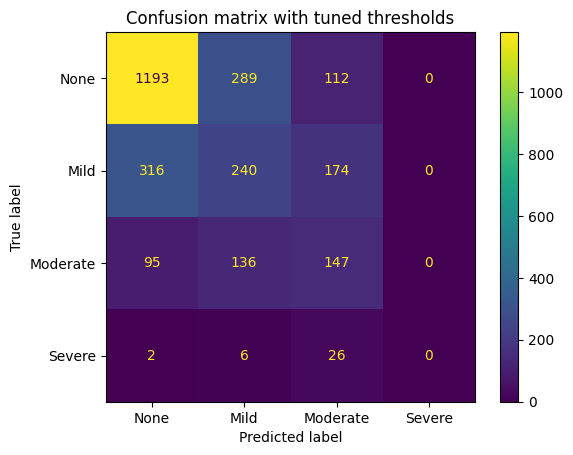

In [51]:
def round_with_thresholds(raw_preds, thresholds):
    """주어진 기준값을 사용하여 원시 예측값을 반올림하는 함수

    매개변수
    ----------
    raw_preds: 회귀 모델의 원시 예측값, n_samples 길이의 실수 배열
    thresholds: 3개의 기준값을 가진 실수 배열

    반환값
    -------
    rounded_preds: 반올림된 예측값, 0..3 범위 내의 정수 배열
    """
    return np.where(raw_preds < thresholds[0], 0,
                    np.where(raw_preds < thresholds[1], 1,
                             np.where(raw_preds < thresholds[2], 2, 3)))


def fun(thresholds, y_true, raw_preds):
    """최소화할 함수: 음의 quadratic kappa score 계산

    매개변수
    ----------
    thresholds: (3, ) 모양의 ndarray, 기준값 배열
    y_true: 실제 값 배열, (n_samples, ) 모양의 ndarray
    raw_preds: 원시 예측값 배열, (n_samples, ) 모양의 ndarray

    반환값
    -------
    quadratic kappa score에 음수를 적용한 값, 주어진 기준값으로 반올림된 예측값에 대해 계산된 값
    """
    rounded_preds = round_with_thresholds(raw_preds, thresholds)
    return - cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

# 최적의 quadratic kappa score를 얻을 수 있는 기준값을 찾기 위한 최적화
res = minimize(fun, x0=[0.5, 1.5, 2.5], args=(y, oof_raw), method='Nelder-Mead')
assert res.success  # 최적화가 성공했는지 확인

# 최적의 기준값으로 예측값 반올림
oof_tuned = round_with_thresholds(oof_raw, res.x)
print(f"# 최적화된 기준값: {res.x.round(2)}")
print(f"# 기본 반올림을 사용한 점수: {cohen_kappa_score(y, oof, weights='quadratic'):.3f}")
print(f"# 최적화된 기준값을 사용한 점수: {cohen_kappa_score(y, oof_tuned, weights='quadratic'):.3f}")

# 최적화된 기준값을 사용한 혼동 행렬 표시
ConfusionMatrixDisplay.from_predictions(y, oof_tuned)
plt.title('Confusion matrix with tuned thresholds')
plt.xticks(np.arange(4), target_labels)  # x축 레이블 설정
plt.yticks(np.arange(4), target_labels)  # y축 레이블 설정
plt.show()


# Conclusion and next steps

We have seen how to cross-validate a model for problematic Internet use and how to tune the rounding thresholds.

The logical next steps are:
1. Connect the elements of the notebook so that it produces a submission file for the competition.
2. Integrate the actigraphy time series into the model.